# Blood Smear Classification

We'll compare the performance of a dense neural network and of a convolutional neural network with a dense top for the classification of blood smears in a dataset of blood smears containing blood cells with and without malaria. 

## Load Malaria Dataset

We load and uncompress the malaria dataset available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.

This dataset was origianlly published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

## Visualize Data

We load the data in a dataset for further processing using the `ImageFolder` class.

In [2]:
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "cell_images")
dataset = ImageFolder(base_dir)

We implement the function `plot_blood_smears`, save it in `fnc_blood_smears.py` ...

```python
def plot_blood_smears(dataset, parasitized):
    import matplotlib.pyplot as plt
    from numpy.random import randint
    import torch

    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
            
        ax.imshow(image)
        ax.set_title(f"Uninfected ({label})" if label == parasitized 
                     else f"Parasitized ({label})")

    plt.tight_layout()
    plt.show()
```

... and use it to visualize some of the blood smears.

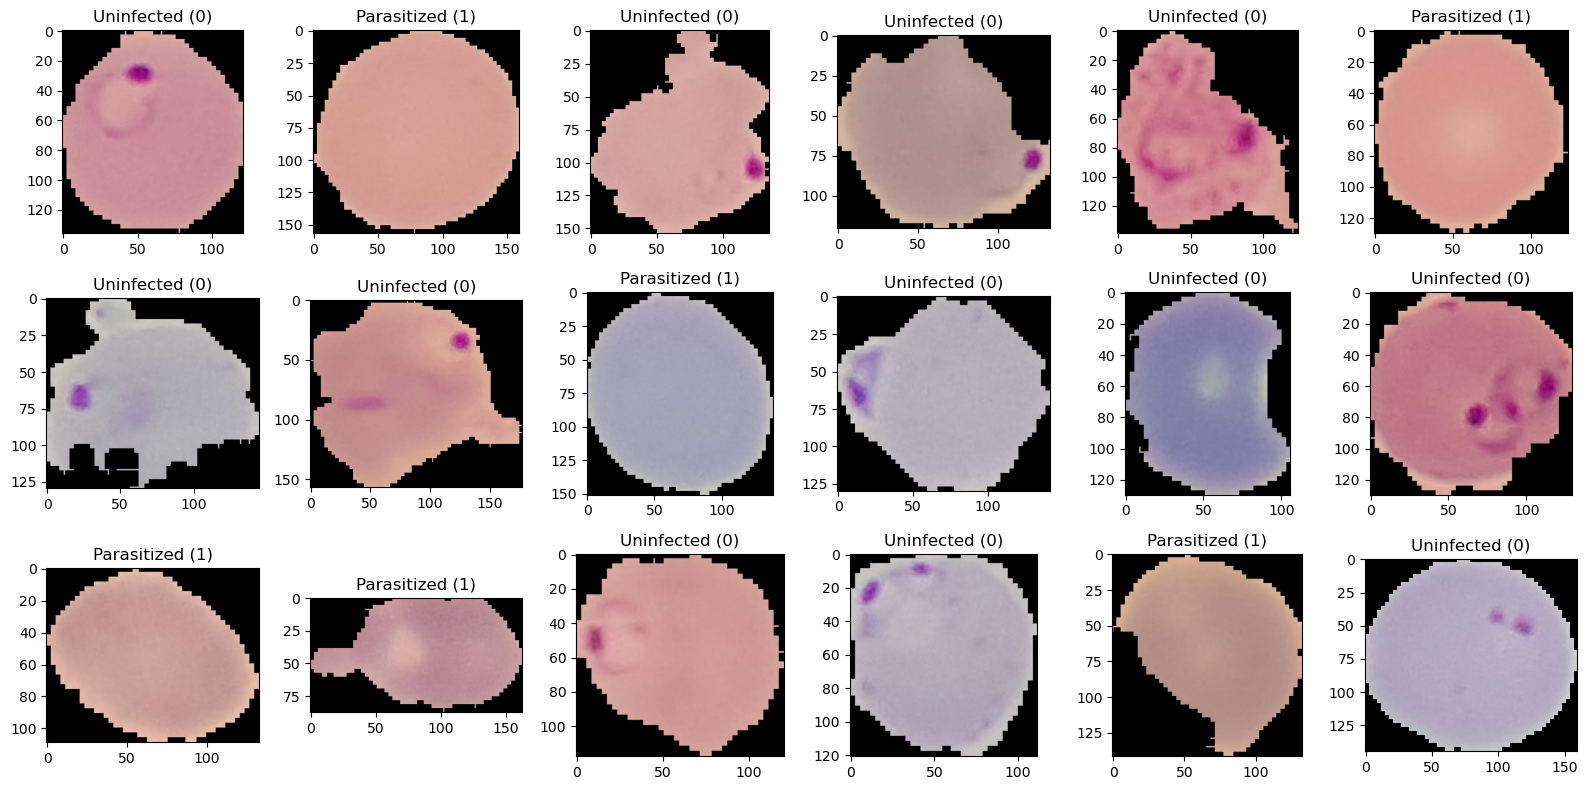

In [3]:
from fnc_blood_smears import plot_blood_smears

plot_blood_smears(dataset, parasitized=0)

## Transform Images and Labels

We define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1).

In [4]:
from torchvision.transforms import Compose, Resize, ToTensor

image_transform = Compose([Resize((28, 28)), ToTensor()])

We assign binary labels to the images, coresponding to their class. We define a transformation to make the target label equal to 0 for the uninfected cells and to 1 for the parasitized ones, which is standard for medical statistical analysis, achieved through `abs(1 - target)`. This step is followed by converting it into a PyTorch tensor using `tensor()`, ensuring the data is in the correct format for PyTorch operations. Next, we convert the tensor into a floating-point type with `float()`, enhancing its compatibility with PyTorch's computational requirements. Finally, we add a new dimension to the tensor using `unsqueeze(-1)`, preparing it for batch processing in neural network models.

In [5]:
from torch import tensor

def label_transform(target):
    return tensor(abs(1 - target)).float().unsqueeze(-1)

We then set up a dataset where images are loaded from a structured directory (`base_dir`).

In [6]:
dataset = ImageFolder(base_dir, 
                      transform=image_transform, 
                      target_transform=label_transform)

We now plot the transformed images and labels.

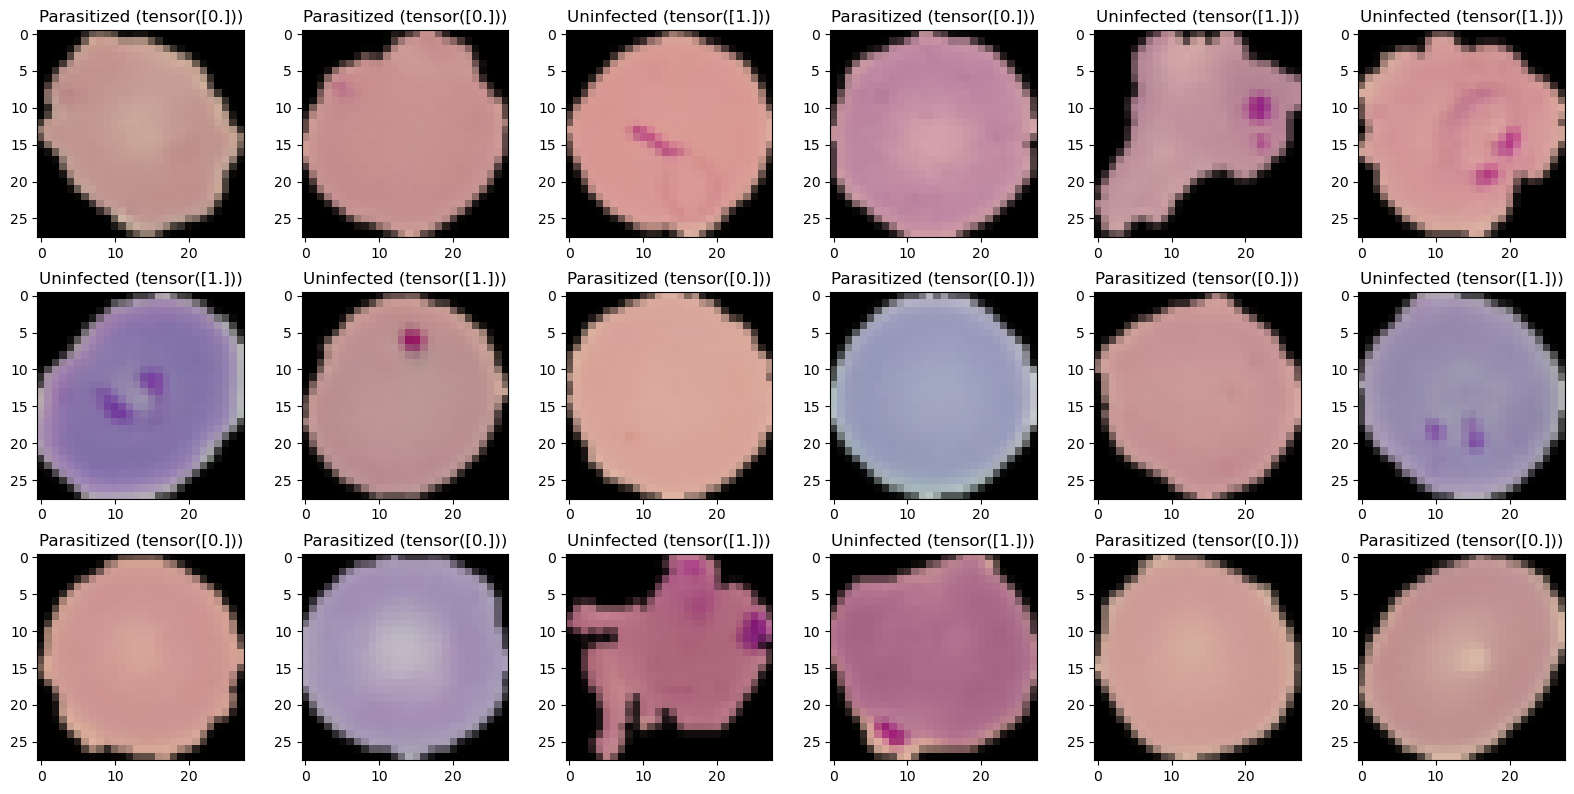

In [7]:
plot_blood_smears(dataset, parasitized=1)

## Split Dataset

We split the dataset, composed by ca. 27,000 cell images, into `train` (80%) and `test` (20%) sets.

In [ ]:
from torch.utils.data import random_split

train, test = random_split(dataset, [0.8, 0.2])

Finally, we define the dataloaders for both sets.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

## Dense Neural Network

We define a dense neural network (DNN) using `deeplay` with 2 layers with 128 neurons.

In [ ]:
import deeplay as dl
from torch.nn import Sigmoid

dnn = dl.MultiLayerPerceptron(
    in_features=28 * 28 * 3,
    hidden_features=[128, 128],
    out_features=1,
    out_activation=Sigmoid,
)

print(dnn)

We then compile the DNN as a classifier.

In [ ]:
dnn_classifier_template = dl.BinaryClassifier(model=dnn, 
                                              optimizer=dl.RMSprop(lr=0.001))
dnn_classifier = dnn_classifier_template.create()

print(dnn_classifier)

### Train

We train the DNN classifier ...

In [ ]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(dnn_classifier, train_loader)

... and evaluate its performance over the training set.

In [ ]:
dnn_trainer.test(dnn_classifier, test_loader);

### Plot ROC Curve

We calculate and visualize the receiver operator curve (ROC) and the value of the corresponding area under the curve (AUC).

For doing this we implement the `` function, save it in `fnc_blood_smear.py` ...

```python
def plot_roc(classifier, loader):
    import torchmetrics as tm

    roc = tm.ROC(task="binary")

    for image, label in loader:
        roc.update(classifier(image), label.long())

    fig, ax = roc.plot(score=True)
    ax.grid(False)
    ax.axis("square")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right")
```

... and use it to plot the ROC curve.

In [ ]:
from fnc_blood_smears import plot_roc

plot_roc(dnn_classifier, test_loader)

## Convolutional Neural Network with a Dense Top

We now build a convolutional neural network (CNN) with a dense top using `deeplay`.


In [ ]:
from torch.nn import AdaptiveAvgPool2d, MaxPool2d

conv_base = dl.ConvolutionalNeuralNetwork(in_channels=3,
                                          hidden_channels=[32, 32, 64],
                                          out_channels=64)
conv_base.blocks[2].pool.configure(MaxPool2d, kernel_size=2)

connector = dl.Layer(AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(in_features=64,
                                    hidden_features=[],
                                    out_features=1,
                                    out_activation=Sigmoid)

cnn = dl.Sequential(conv_base, connector, dense_top)

print(cnn)

We then define a classifier using the CNN.

In [ ]:
cnn_classifier_template = dl.BinaryClassifier(model=cnn,
                                              optimizer=dl.RMSprop(lr=0.001))
cnn_classifier = cnn_classifier_template.create()

print(cnn_classifier)

### Train

We train the CNN classifier...

In [ ]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

... and evaluate its performance over the test set.

In [ ]:
cnn_trainer.test(cnn_classifier, test_loader);

### Plot ROC Curve

We finally display the ROC curve with the AUC value.

In [ ]:
plot_roc(cnn_classifier, test_loader)

## Failure analysis

We now write the `plot_failures` function, save it in `fnc_blood_smears.py` ...

```python
def plot_failures(images, labels, pred, threshold=.5, plot_num=5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze
    
    pred = array(pred).squeeze()
    labels = array(labels).squeeze()
    images = array(images)

    false_positives = (pred > threshold) & (labels == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred < threshold) & (labels == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(plot_num * 2, 5))
    for i in range(plot_num):
        # false positives
        plt.subplot(2, plot_num, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, plot_num, plot_num + i + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()
```

... and visualize some of the wrongly classified cells, looking for common patterns.

In [ ]:
from fnc_blood_smears import plot_failures
from torch import stack

images, gt = zip(*test)
pred = cnn_classifier(stack(images)).tolist()

plot_failures(images, gt, pred)

## Access Filters

We can access value of the filters used by the neural network. The follwoing code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[31]`). 

In [ ]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[31]

print(filter)

## Activations

We pick the image of an infected smear to then check the activations it produces on the last convolutional layer.

In [ ]:
from PIL import Image

im_ind = 0  # Select the index of an image

image_hr = Image.open(dataset.samples[im_ind][0])  # Retrieve the original image corresponding to the selected index.
image = image_transform(image_hr)  # Apply the same transformation used in preprocessing

label = label_transform(dataset.targets[im_ind])
print(label)  # Check that it corresponds to a Parasitized image (label = 1)

To visualize the network features, we can use `hooks`. These are functionalities that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients.

To plot the activations, we use the `plot_activations()` function ...

```python
def plot_activations(activations, cols=8):
    from matplotlib import pyplot as plt

    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i)

    fig.tight_layout()
    plt.show()
```

... which is added to `fnc_blood_smears.py`.

In [ ]:
def hook_func(layer, input, output):
    from fnc_blood_smears import plot_activations
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_classifier.model[0].blocks:
    layer = block.layer
    handle_fwd_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_classifier.model(image.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_fwd_hook.remove()

## Visalizing Heatmaps with Grad-CAM

We can also use hooks to keep tracks also of the gradients in the backward pass.

In [ ]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

try:
    pred = cnn_classifier.model(image.unsqueeze(0))
    pred.backward()
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
finally:
    handle_fwd_hook.remove()
    handle_bwd_hook.remove()

We can now calculate the heatmap combining activations and gradients.

In [ ]:
from torch.nn.functional import relu

activations = hookdata["activations"][0]
gradients = hookdata["gradients"][0]

pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
heatmap = relu((pooled_gradients * activations).sum(0)).detach().numpy()

We can also combine activations and gradients to calculate Grad-CAM and inspect on which part of an image the CNN focuses on to predict its outputs, using the `def plot_heatmap()` function, which is added to `fns_blood_smears.py`.

```python
def plot_heatmap(image, heatmap):
    from matplotlib import pyplot as plt
    import skimage
    from numpy import array

    image = skimage.exposure.rescale_intensity(array(image), out_range=(0, 1))
    heatmap = skimage.transform.resize(heatmap, image.shape, order=2)
    heatmap = skimage.exposure.rescale_intensity(heatmap, out_range=(0.25, 1))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, interpolation="bilinear")
    plt.title("Original image", fontsize=16)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap.mean(axis=-1), interpolation="bilinear")
    plt.title("Heatmap with Grad-CAM", fontsize=16)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image * heatmap)
    plt.title("Overlay", fontsize=16)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
```

In [ ]:
from fnc_blood_smears import plot_heatmap

plot_heatmap(image_hr, heatmap)

## Implementat Hooks with Context Managers

We define them as context manager classes, so that we can use them with the `with` statement. This ensures that the hooks are properly set up and removed when they are no longer needed, preventing potential side effects or memory leaks. This is particularly important in complex neural network models where maintaining computational efficiency and correctness is crucial.

Activations at a specific layer can be obtained from the forward pass using the `fwd_hook` class:

* The `__init__(self, layer)` method registers a forward hook to the provided model at a specific layer. The hook is set to the `hook_func()` method. This hook will be called every time the forward method of the model is executed.

* The `hook_func(self, layer, i, o)` method is called during the forward pass of the model: `layer` is the layer to which the hook is attached; `input` is the input to the model's layer; and `o` is the output from the model's layer. The output `o` is detached from the current computation graph and cloned to prevent any modifications to `o` from affecting the original tensor, and avoids potential issues with backpropagation. Note: `o[0]` is used because `o` is a tuple of activations, one for each image.

* The `__enter__(self, *args)` method returns this object when entering the context (using the `with` statement).

* The `__exit__(self, *args)` method removes the forward hook from the model when exiting the context. This is important for resource management and to ensure that the hook does not remain active beyond its intended scope.

```python
class fwd_hook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, i, o):
        print("Forward hook running ...") 
        self.activations = o.detach().clone()
        print(f"Activations size: {self.activations.size()}")

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()
```

Gradients at a specific layer can be obtained from the backward pass using the `bwd_hook` class:

* The `__init__(self, layer)` method registers a full backward hook to the provided model at a specific layer. The hook is set to the `hook_func`` method. This hook will be called every time the backward pass of the model is executed.

* The `hook_func(self, layer, gi, go)` function is called during the backward pass of the model: `layer` is the layer to which the hook is attached; `gi` represents the gradients with respect to the input; and `go` represents the gradients with respect to the output. The first output gradient `go[0]` is detached from the current computation graph and cloned. This prevents any modifications to `go[0]` from affecting the original tensor, and avoids potential issues with backpropagation. Note: `go[0]` is used because `go` is a tuple of gradients, one for each output (even though in this case we only have one input).

* The `__enter__(self, *args)` method returns this object when entering the context (using the `with` statement).

* The `__exit__(self, *args)` method removes the backward hook from the model when exiting the context. This is important to ensure that the hook is only active during the intended scope and to release any resources associated with the hook.

```python
class bwd_hook():
    def __init__(self, layer):
        self.hook = layer.register_full_backward_hook(self.hook_func)

    def hook_func(self, layer, gi, go):
        print("Backward hook running ...")
        self.gradients = go[0].detach().clone()
        print(f"Gradients size: {self.gradients.size()}")

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()
```

We add both classes to `fnc_blood_smears.py`.

In [ ]:
from fnc_blood_smears import fwd_hook, bwd_hook

layer = cnn_classifier.model[0].blocks[3].layer

with bwd_hook(layer) as bh, fwd_hook(layer) as fh:
    pred = cnn_classifier.model(image.unsqueeze(0))  # Forward pass through the model with the given image
    pred.backward()  # Executing the backward pass for backpropagation

In [ ]:
from fnc_blood_smears import plot_activations

plot_activations(fh.activations[0])

In [ ]:
from torch.nn.functional import relu
from fnc_blood_smears import plot_heatmap

pooled_gradients = bh.gradients[0].mean(dim=[1, 2], keepdim=True)
grad_cam = relu((pooled_gradients * fh.activations[0]).sum(0)).detach().numpy()

plot_heatmap(image_hr, grad_cam)